# PREP

In [1]:
import os
import numpy as np
import math
import pandas as pd
import re
from functools import reduce
from collections import OrderedDict
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score
)
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

2023-07-19 14:59:11.789716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-19 14:59:14.490659: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-19 14:59:14.490994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-19 14:59:14.667024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-19 14:59:14.667925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-

## SET MD4 OR MD5 / RESULTDIR

In [93]:
# REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'
REPODIR = '/home/wimmerl/projects/wildlife-experiments/'
RESULTDIR = os.path.join(REPODIR, 'results', 'bavaria', 'md5')
DATADIR = os.path.join(REPODIR, 'data', 'bavaria', 'md5')
FIGDIR = os.path.join(REPODIR, 'figures', 'bavaria', 'md5')
LABEL_MAP = load_json(os.path.join(DATADIR, 'label_map.json'))
# RESULTDIR = os.path.join(REPODIR, 'results', 'channel_islands')
# DATADIR = os.path.join(REPODIR, 'data', 'channel_islands')
# FIGDIR = os.path.join(REPODIR, 'figures', 'channel_islands')
# LABEL_MAP = load_json(os.path.join(DATADIR, 'label_map_names.json'))
EMPTY_CLASS = LABEL_MAP.get('empty')

# SUFFIX_PKL = '.pkl'
# SUFFIX = ''
# OUR_THRESH = 0.5
SUFFIX_PKL = '_md5.pkl'
SUFFIX = 'md5'
OUR_THRESH = 0.1

In [94]:
LABEL_MAP

{'empty': 0,
 'european_hare': 1,
 'others': 2,
 'red_deer': 3,
 'red_fox': 4,
 'red_squirrel': 5,
 'roe_deer': 6,
 'wild_boar': 7}

In [95]:
CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'xticks_rotation': 45,
    'colorbar': False,
    'cmap': 'Blues',
}
CONFMAT_PLT_ARGS = {
    'figure.figsize': (6, 6),
    'font.size': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.alignment': 'right'
}
THRESHOLDS = [0.1, 0.3, 0.5, 0.7, 0.9]
ITERATIONS = list(range(8))[1:]
RANDOM_SEEDS = ['123', '456', '789']

## DATA

In [96]:
FILES_INSAMPLE = [
    [
        os.path.join(RESULTDIR, 'passive', t, f) for f in os.listdir(os.path.join(RESULTDIR, 'passive', t)) 
        if re.search(r'(insample_test_)+(\d+)' + re.escape(SUFFIX_PKL), f)
    ] 
    for t in [str(int(100 * ts)) for ts in THRESHOLDS]
]
FILES_OOSAMPLE = [
    os.path.join(RESULTDIR, 'passive', str(int(100 * OUR_THRESH)), f) 
    for f in os.listdir(os.path.join(RESULTDIR, 'passive', str(int(100 * OUR_THRESH)))) 
    if re.search(r'(oosample_)+(\d+)' + re.escape(SUFFIX_PKL), f)
]
FILES_ACTIVE_OPTIMAL = [
    os.path.join(RESULTDIR, 'active', 'optimal', f) 
    for f in os.listdir(os.path.join(RESULTDIR, 'active', 'optimal'))
    if re.search(r'(active_optimal_)+(\d+)' + re.escape(SUFFIX_PKL), f)
]
FILES_ACTIVE_COLDSTART = [
    os.path.join(RESULTDIR, 'active', 'coldstart', 'entropy', rs) for rs in RANDOM_SEEDS
]
FILES_ACTIVE_WARMSTART = [
    os.path.join(RESULTDIR, 'active', 'warmstart', 'entropy', rs) for rs in RANDOM_SEEDS
]

In [98]:
# RESULT_FILE = {**RESULTS_INSAMPLE_TEST_01, **RESULTS_INSAMPLE_TEST_05}
PREDS = 'preds_imgs_ppl'
TRUTH = 'truth_imgs_ppl'

In [99]:
def sort_results(dict_preds, truth):
    ordered_dict = {k: dict_preds[k] for k in sorted(list(dict_preds.keys()))}
    ordered_array = np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(ordered_dict.values())])
    ordered_list = [truth[k] for k in [list(dict_preds.keys()).index(i) for i in sorted(list(dict_preds.keys()))]]
    return ordered_array, ordered_list

# IN-SAMPLE

## PERFORMANCE ACROSS THRESHOLDS ON TEST

Using varying thresholds for the MD, how well is our pipeline able to 1) classify images overall, 2) detect empty images correctly?

In [100]:
rows_multiclass_avg, rows_multiclass_se = [], []
rows_empty_avg, rows_empty_se = [], []

for idx, t in enumerate(THRESHOLDS):
    
    results_t = [f for f in FILES_INSAMPLE[idx]]
    accs, precs, recs, fones = [], [], [], []
    accs_empty, precs_empty, recs_empty, fones_empty = [], [], [], []
    precs_nonempty, recs_nonempty, fones_nonempty = [], [], []
    
    for rt in results_t:
        
        r = load_pickle(rt)
        preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r[PREDS], r[TRUTH])
        y_true = truth_imgs_ppl_t
        y_pred = [np.argmax(v) for v in preds_imgs_ppl_t]
        report = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=[k for k, v in LABEL_MAP.items() if v in set(y_true) | set(y_pred)],
            zero_division=0,
            output_dict=True,
        )
        
        accs.append(report['accuracy'])
        precs.append(report['weighted avg']['precision'])
        recs.append(report['weighted avg']['recall'])
        fones.append(report['weighted avg']['f1-score'])
        
        conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
        tn, fp, fn, tp = conf_empty.ravel()
        accs_empty.append((tn + tp) / (tn + fp + fn + tp))
        precs_empty.append(report['empty']['precision'])
        recs_empty.append(report['empty']['recall'])
        fones_empty.append(report['empty']['f1-score'])
        precs_nonempty.append(tn / (tn + fn))
        recs_nonempty.append(tn / (tn + fp))
        fones_nonempty.append(2 * tn / (2 * tn + fn + fp))
        
    accs = np.array(accs)
    precs = np.array(precs)
    recs = np.array(recs)
    fones = np.array(fones)
    rows_multiclass_avg_t = [t]
    rows_multiclass_avg_t.extend(
        [np.round(x, 3) for x in [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)]]
    )
    rows_multiclass_avg.append(rows_multiclass_avg_t)
    rows_multiclass_se_t = [t]
    rows_multiclass_se_t.extend(
        [
            np.round(x, 3) for x in [
                np.std(accs) / math.sqrt(len(accs)),
                np.std(precs) / math.sqrt(len(precs)),
                np.std(recs) / math.sqrt(len(recs)),
                np.std(fones) / math.sqrt(len(fones))
            ]
            
        ]
        
    )
    rows_multiclass_se.append(rows_multiclass_se_t)
    accs_empty = np.array(accs_empty)
    precs_empty = np.array(precs_empty)
    recs_empty = np.array(recs_empty)
    fones_empty = np.array(fones_empty)
    precs_nonempty = np.array(precs_nonempty)
    recs_nonempty = np.array(recs_nonempty)
    fones_nonempty = np.array(fones_nonempty)
    rows_empty_avg_t = [t]
    rows_empty_avg_t.extend(
        [
            np.round(x, 3) for x in [
                np.mean(accs_empty), 
                np.mean(precs_empty), 
                np.mean(recs_empty), 
                np.mean(fones_empty),
                np.mean(precs_nonempty), 
                np.mean(recs_nonempty), 
                np.mean(fones_nonempty)                
            ]
        ]
    )
    rows_empty_avg.append(rows_empty_avg_t)
    rows_empty_se_t = [t]
    rows_empty_se_t.extend(
        [
            np.round(x, 3) for x in [
                np.std(accs_empty) / math.sqrt(len(accs_empty)),
                np.std(precs_empty) / math.sqrt(len(precs_empty)),
                np.std(recs_empty) / math.sqrt(len(recs_empty)),
                np.std(fones_empty) / math.sqrt(len(fones_empty)),
                np.std(precs_empty) / math.sqrt(len(precs_nonempty)),
                np.std(recs_empty) / math.sqrt(len(recs_nonempty)),
                np.std(fones_empty) / math.sqrt(len(fones_nonempty))
            ]
            
        ]
        
    )
    rows_empty_se.append(rows_empty_se_t)
COLNAMES = ['threshold', 'acc', 'prec', 'rec', 'fone']
COLNAMES_EMPTY = ['threshold', 'acc', 'prec', 'rec', 'fone', 'prec_ne', 'rec_ne', 'fone_ne']
df_ins_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_ins_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)
df_ins_empty_avg = pd.DataFrame(rows_empty_avg, columns=COLNAMES_EMPTY)
df_ins_empty_se = pd.DataFrame(rows_empty_se, columns=COLNAMES_EMPTY)

In [51]:
df_ins_multiclass_avg  # Table 3

,threshold,acc,prec,rec,fone
0,0.1,0.994,0.995,0.994,0.995
1,0.3,0.992,0.993,0.992,0.992
2,0.5,0.994,0.994,0.994,0.994
3,0.7,0.991,0.991,0.991,0.991
4,0.9,0.985,0.984,0.985,0.982


In [52]:
df_ins_empty_avg  # Table 2

,threshold,acc,prec,rec,fone,prec_ne,rec_ne,fone_ne
0,0.1,0.995,0.998,0.997,0.997,0.911,0.922,0.916
1,0.3,0.993,0.998,0.994,0.996,0.845,0.941,0.888
2,0.5,0.995,0.997,0.998,0.997,0.932,0.895,0.912
3,0.7,0.993,0.995,0.997,0.996,0.909,0.845,0.875
4,0.9,0.986,0.985,1.000,0.993,1.000,0.534,0.696


In [53]:
df_ins_multiclass_avg.to_csv(os.path.join(RESULTDIR, 'passive', 'insample.csv'))
df_ins_empty_avg.to_csv(os.path.join(RESULTDIR, 'passive', 'insample_empty.csv'))

## PERFORMANCE

In [101]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_INSAMPLE[1]]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
print(  # Figure 3
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=[k for k, v in LABEL_MAP.items() if v in set(y_trues) | set(y_preds)],
    )
)

               precision    recall  f1-score   support

        empty       0.95      0.99      0.97      7017
european_hare       0.80      0.65      0.72       192
       others       0.61      0.43      0.50       453
     red_deer       0.69      0.75      0.72        12
      red_fox       0.83      0.74      0.78       303
 red_squirrel       0.87      0.79      0.83       141
     roe_deer       0.95      0.91      0.93      2778
    wild_boar       0.78      0.78      0.78        72

     accuracy                           0.93     10968
    macro avg       0.81      0.75      0.78     10968
 weighted avg       0.93      0.93      0.93     10968



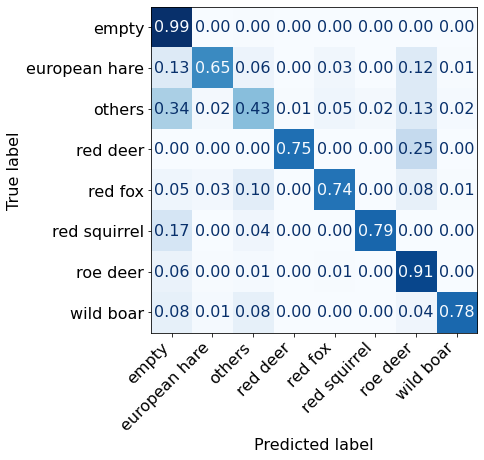

In [105]:
ConfusionMatrixDisplay.from_predictions(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds), 
    display_labels = [k.replace('_', ' ') for k, v in LABEL_MAP.items() if v in set(y_true) | set(y_pred)], 
#     display_labels = ['empty', 'fox', 'rodent', 'bird'],
    **CONFMAT_ARGS
)
plt.rcParams.update(CONFMAT_PLT_ARGS)
plt.savefig(os.path.join(FIGDIR, 'cm_insample.eps'), bbox_inches='tight')
plt.savefig(os.path.join(FIGDIR, 'cm_insample.png'), bbox_inches='tight')

# OUT-OF-SAMPLE

## PERFORMANCE

In [106]:
rows_multiclass_avg, rows_multiclass_se = [], []
accs, precs, recs, fones = [], [], [], []

for r in [f for f in FILES_OOSAMPLE]:
    r = load_pickle(r)
    preds_imgs_ppl, truth_imgs_ppl = sort_results(r[PREDS], r[TRUTH])
    y_true = truth_imgs_ppl
    y_pred = [np.argmax(v) for v in preds_imgs_ppl]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=[k for k, v in LABEL_MAP.items() if v in set(y_true)],
        zero_division=0,
        output_dict=True,
    )
    accs.append(report['accuracy'])
    precs.append(report['weighted avg']['precision'])
    recs.append(report['weighted avg']['recall'])
    fones.append(report['weighted avg']['f1-score'])
accs = np.array(accs)
precs = np.array(precs)
recs = np.array(recs)
fones = np.array(fones)
rows_multiclass_avg.append([np.round(x, 3) for x in [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)]])
rows_multiclass_se.append(
    [
        np.round(x, 3) for x in [
            np.std(accs) / math.sqrt(len(accs)),
            np.std(precs) / math.sqrt(len(precs)),
            np.std(recs) / math.sqrt(len(recs)),
            np.std(fones) / math.sqrt(len(fones))
        ]
        
    ]

)
COLNAMES = ['acc', 'prec', 'rec', 'fone']
df_oos_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_oos_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)

In [68]:
acc_al_lower_limit, rec_al_lower_limit = rows_multiclass_avg[0][0], rows_multiclass_avg[0][1]

In [69]:
df_multiclass_avg = pd.concat(
    [df_ins_multiclass_avg.loc[df_ins_multiclass_avg['threshold'] == OUR_THRESH], df_oos_multiclass_avg]
)
df_multiclass_avg.index = ['ins', 'oos']

In [70]:
df_multiclass_se = pd.concat(
    [df_ins_multiclass_se.loc[df_ins_multiclass_se['threshold'] == OUR_THRESH], df_oos_multiclass_se]
)
df_multiclass_se.index = ['ins', 'oos']

In [71]:
df_multiclass_avg.drop(['threshold'], axis=1).to_csv(os.path.join(RESULTDIR, 'passive', 'oosample.csv'))

In [107]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_OOSAMPLE]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))

In [90]:
print(
    classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=[k for k, v in LABEL_MAP.items() if v in set(y_true)],
        zero_division=0,
        output_dict=False,
    )
)

              precision    recall  f1-score   support

       empty       0.97      0.99      0.98      2389
         fox       0.88      0.99      0.93      2415
       skunk       0.00      0.00      0.00        34
      rodent       0.91      0.19      0.31       312
        bird       0.98      0.38      0.55       118

    accuracy                           0.92      5268
   macro avg       0.75      0.51      0.55      5268
weighted avg       0.92      0.92      0.90      5268



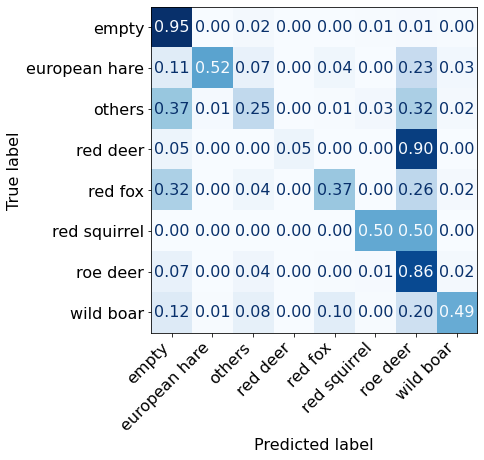

In [108]:
ConfusionMatrixDisplay.from_predictions(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds), 
    display_labels=[k.replace('_', ' ') for k, v in LABEL_MAP.items() if v in set(y_true) | set(y_pred)], 
    **CONFMAT_ARGS
)
plt.rcParams.update(CONFMAT_PLT_ARGS)
plt.savefig(os.path.join(FIGDIR, 'cm_oosample.eps'), bbox_inches='tight')
plt.savefig(os.path.join(FIGDIR, 'cm_oosample.png'), bbox_inches='tight')

## ACTIVE LEARNING

In [82]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_ACTIVE_OPTIMAL]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
report_dict = classification_report(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds),
    target_names=[k for k, v in LABEL_MAP.items() if v in set(y_true)], 
    output_dict=True,
    zero_division=0
)
acc_al_upper_limit, rec_al_upper_limit = report_dict['accuracy'], report_dict['weighted avg']['precision']

In [84]:
print(  # Figure 5
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=[k for k, v in LABEL_MAP.items() if v in set(y_true) | set(y_pred)],
        zero_division=0,
        output_dict=True,
    )

) 

{'empty': {'precision': 0.970483738726428, 'recall': 0.990930654388168, 'f1-score': 0.9806006213324128, 'support': 7167}, 'fox': {'precision': 0.9892413793103448, 'recall': 0.9899240855762594, 'f1-score': 0.9895826146947223, 'support': 7245}, 'skunk': {'precision': 0.927710843373494, 'recall': 0.7549019607843137, 'f1-score': 0.8324324324324324, 'support': 102}, 'rodent': {'precision': 0.9527272727272728, 'recall': 0.8397435897435898, 'f1-score': 0.8926746166950597, 'support': 936}, 'bird': {'precision': 0.9725609756097561, 'recall': 0.9011299435028248, 'f1-score': 0.9354838709677419, 'support': 354}, 'accuracy': 0.9779802581624905, 'macro avg': {'precision': 0.9625448419494591, 'recall': 0.8953260467990312, 'f1-score': 0.9261548312244738, 'support': 15804}, 'weighted avg': {'precision': 0.9778016051137962, 'recall': 0.9779802581624905, 'f1-score': 0.9775438835870621, 'support': 15804}}


In [85]:
# compute relative sample size per iteration (sizes hard-coded for training)
n_obs = len(y_trues)
init_batches = [2**x for x in range(7, 13)] # !!
batch_sizes = init_batches + [n_obs - sum(init_batches)]
batch_sizes_cs = np.cumsum([x / n_obs for x in batch_sizes])

In [23]:
batch_sizes

[128, 256, 512, 1024, 2048, 4096, 2625]

In [24]:
batch_sizes_cs

array([0.01197493, 0.03592478, 0.08382449, 0.17962391, 0.37122275,
       0.75442043, 1.        ])

In [86]:
ITERATION_EXTRACT = 4

{'empty': {'precision': 0.9317747390089692, 'recall': 0.9926378446115288, 'f1-score': 0.9612438376943497, 'support': 6384}, 'european_hare': {'precision': 0.95, 'recall': 0.34234234234234234, 'f1-score': 0.5033112582781457, 'support': 111}, 'others': {'precision': 0.6120689655172413, 'recall': 0.3242009132420091, 'f1-score': 0.42388059701492536, 'support': 438}, 'red_deer': {'precision': 0.5263157894736842, 'recall': 0.16666666666666666, 'f1-score': 0.25316455696202533, 'support': 60}, 'red_fox': {'precision': 1.0, 'recall': 0.05263157894736842, 'f1-score': 0.1, 'support': 57}, 'red_squirrel': {'precision': 1.0, 'recall': 0.16666666666666666, 'f1-score': 0.2857142857142857, 'support': 6}, 'roe_deer': {'precision': 0.9044186775305547, 'recall': 0.8948837209302326, 'f1-score': 0.8996259351620948, 'support': 3225}, 'wild_boar': {'precision': 0.7910447761194029, 'recall': 0.7794117647058824, 'f1-score': 0.7851851851851852, 'support': 408}, 'accuracy': 0.9107493685096828, 'macro avg': {'pre

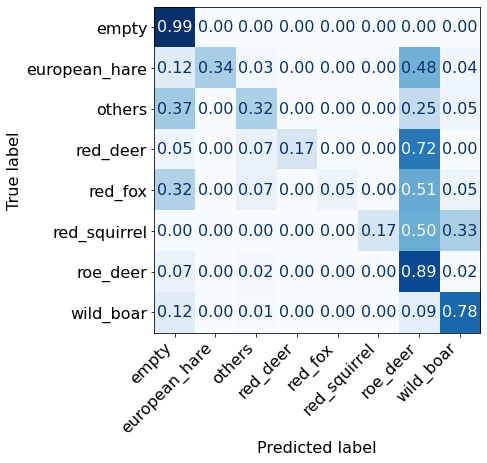

In [29]:
acc_coldstart_avg, rec_coldstart_avg = [], []
acc_coldstart_se, rec_coldstart_se = [], []
acc_warmstart_avg, rec_warmstart_avg = [], []
acc_warmstart_se, rec_warmstart_se = [], []
fone_coldstart_avg = []

for i in ITERATIONS: # !!
    acc_coldstart, rec_coldstart = [], []
    acc_warmstart, rec_warmstart = [], []
    fone_coldstart = []
    y_trues, y_preds = np.empty(0), np.empty(0)
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_COLDSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS)
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_cs = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=[k for k, v in LABEL_MAP.items() if v in set(y_true)],
            output_dict=True,
            zero_division=0
        )
        acc_coldstart.append(report_dict_cs['accuracy'])
        rec_coldstart.append(report_dict_cs['weighted avg']['precision'])
        fone_coldstart.append(report_dict_cs['macro avg']['f1-score'])
        if i == ITERATION_EXTRACT:
            y_trues = np.concatenate((y_trues, y_true))
            y_preds = np.concatenate((y_preds, y_pred))
    if i == ITERATION_EXTRACT:
        ConfusionMatrixDisplay.from_predictions(
            y_true=np.array(y_trues), 
            y_pred=np.array(y_preds), 
            display_labels = [k.replace('_', ' ') for k, v in LABEL_MAP.items() if v in set(y_true)| set(y_pred)], 
            **CONFMAT_ARGS
        )
        plt.rcParams.update(CONFMAT_PLT_ARGS)
        plt.savefig(os.path.join(FIGDIR, 'cm_active.eps'), bbox_inches='tight')
        plt.savefig(os.path.join(FIGDIR, 'cm_active.png'), bbox_inches='tight')
        print(
            classification_report(
                y_true=y_trues, 
                y_pred=y_preds,
                target_names=[k for k, v in LABEL_MAP.items() if v in set(y_true)],
                output_dict=True,
                zero_division=0
            )
        )
        df = pd.DataFrame(
            [[report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['f1-score']]], 
            columns=['acc', 'prec', 'fone']
        )
        df.to_csv(os.path.join(RESULTDIR, 'active', f'iteration_{ITERATION_EXTRACT}.csv'))
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_WARMSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS)
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_ws = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=[k for k, v in LABEL_MAP.items() if v in set(y_true)],
            output_dict=True,
            zero_division=0
        )
        acc_warmstart.append(report_dict_ws['accuracy'])
        rec_warmstart.append(report_dict_ws['weighted avg']['precision'])
    acc_coldstart = np.array(acc_coldstart)
    rec_coldstart = np.array(rec_coldstart)
    fone_coldstart = np.array(fone_coldstart)
    acc_coldstart_avg.append(np.mean(acc_coldstart))
    rec_coldstart_avg.append(np.mean(rec_coldstart))
    fone_coldstart_avg.append(np.mean(fone_coldstart))
    acc_coldstart_se.append(np.std(acc_coldstart) / math.sqrt(len(acc_coldstart)))
    rec_coldstart_se.append(np.std(rec_coldstart) / math.sqrt(len(rec_coldstart)))
    acc_warmstart = np.array(acc_warmstart)
    rec_warmstart = np.array(rec_warmstart)
    acc_warmstart_avg.append(np.mean(acc_warmstart))
    rec_warmstart_avg.append(np.mean(rec_warmstart))
    acc_warmstart_se.append(np.std(acc_warmstart) / math.sqrt(len(acc_warmstart)))
    rec_warmstart_se.append(np.std(rec_warmstart) / math.sqrt(len(rec_warmstart)))        

In [27]:
fone_coldstart

array([0.76452418, 0.75173388, 0.75035921])

In [30]:
acc_coldstart_avg[-1] = acc_al_upper_limit
acc_warmstart_avg[-1] = acc_al_upper_limit
acc_coldstart_se[-1] = 0
acc_warmstart_se[-1] = 0

In [29]:
# acc_coldstart_avg += [acc_al_upper_limit]
# acc_warmstart_avg += [acc_al_upper_limit]
# acc_coldstart_se += [0]
# acc_warmstart_se += [0]

In [31]:
# create data for plot
al_perf_acc = {
    'relative_size': batch_sizes_cs,
    'acc_lower_limit': [acc_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'acc_upper_limit': [acc_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'acc_coldstart': acc_coldstart_avg,
    'se_coldstart': acc_coldstart_se,
    'acc_warmstart': acc_warmstart_avg,
    'se_warmstart': acc_warmstart_se,
}
al_perf_rec = {
    'relative_size': batch_sizes_cs,
    'rec_lower_limit': [rec_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'rec_upper_limit': [rec_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'rec_coldstart': rec_coldstart_avg,
    'rec_coldstart_se': rec_coldstart_se,
    'rec_warmstart': rec_warmstart
}

In [32]:
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
# al_perf_rec_pd = pd.DataFrame(al_perf_rec)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


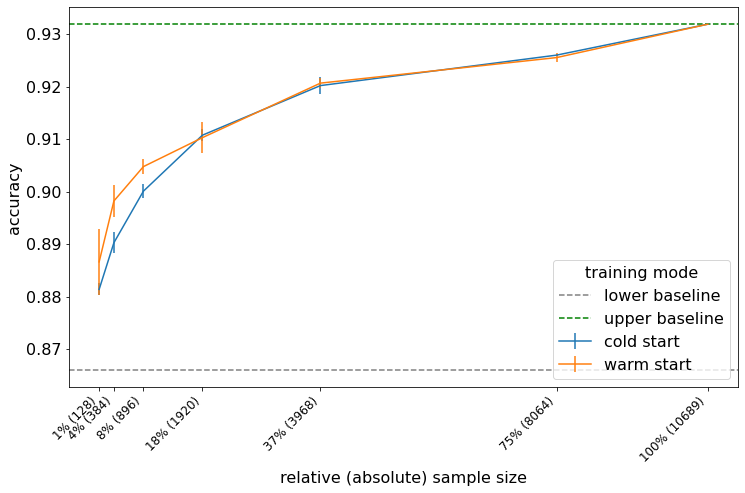

In [34]:
fig, ax = plt.subplots()
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_coldstart'], al_perf_acc_pd['se_coldstart'])
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_warmstart'], al_perf_acc_pd['se_warmstart'])
ax.set_xlabel('relative (absolute) sample size')
ax.set_xticks(al_perf_acc_pd['relative_size'])
dataset_sizes = [
    f' {round(i * 100)}% ({round(j)})' for i, j in zip(al_perf_acc_pd['relative_size'], np.cumsum(batch_sizes))
]
ax.set_xticklabels(dataset_sizes, rotation=45, ha='right')
ax.set_ylabel('accuracy')
ax.axhline(acc_al_lower_limit,color='gray',ls='--')
ax.axhline(acc_al_upper_limit,color='green',ls='--')
ax.legend(
    title='training mode', 
    loc='lower right', 
    labels=['lower baseline', 'upper baseline', 'cold start', 'warm start']
)
plt_args = {
    'figure.figsize': (12, 7),
    'font.size': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 16,
    'xtick.alignment': 'right'
}
plt.rcParams.update(plt_args)
plt.savefig(os.path.join(FIGDIR, 'active_learning.eps'), bbox_inches='tight')
plt.savefig(os.path.join(FIGDIR, 'active_learning.png'), bbox_inches='tight')